# PCA + k-Means on ERA5 Data

## Results

- Data preprocessing takes ~10min
- PCA with 500 PCs takes ~8.5min
- PCA (reduced PCs), Transforming and clustering (2 x k-Means) takes ~3min
- kPCA with 500 PCs takes ~6.5min
- kPCA (reduced PCs), Transforming and clustering (2 x k-Means) takes ~7.5min
- PCA:
  - N_pcs=1 cover 0.2 of the variance
  - N_pcs=2 cover 0.3 of the variance
  - N_pcs=3 cover 0.4 of the variance
  - N_pcs=5 cover 0.5 of the variance
  - N_pcs=10 cover 0.6 of the variance
  - N_pcs=24 cover 0.7 of the variance
  - N_pcs=80 cover 0.8 of the variance
  - N_pcs=171 cover 0.85 of the variance
  - N_pcs=421 cover 0.9 of the variance
- kPCA:
  - N_pcs=1 cover 0.3 of the variance
  - N_pcs=2 cover 0.4 of the variance
  - N_pcs=4 cover 0.5 of the variance
  - N_pcs=6 cover 0.6 of the variance
  - N_pcs=13 cover 0.7 of the variance
  - N_pcs=32 cover 0.8 of the variance
  - N_pcs=103 cover 0.9 of the variance


In [3]:
%load_ext autoreload
%autoreload 2
import datetime
import pathlib
import joblib

import sklearn.cluster
import sklearn.decomposition
import sklearn.preprocessing
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import torch
import pandas as pd

import a6
import a6.plotting._colors as _colors

a6.utils.logging.create_logger(
    global_rank=0,
    local_rank=0,
    verbose=False,
)

path = pathlib.Path(
    "/p/project1/deepacf/emmerich1/data/ecmwf_era5/era5_pl_1964_2023_12.nc"
)
plots = pathlib.Path("/p/project1/deepacf/emmerich1/plots/paper-1")
pca_dir = pathlib.Path("/p/project1/deepacf/emmerich1/data/pca")
kmeans_dir = pathlib.Path("/p/project1/deepacf/emmerich1/data/kmeans")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%%time

ds = xr.open_dataset(path)

coordinates = a6.datasets.coordinates.Coordinates()
variables = a6.datasets.variables.Model()

ds

CPU times: user 530 ms, sys: 127 ms, total: 657 ms
Wall time: 3.22 s


<xarray.Dataset>
Dimensions:    (longitude: 221, latitude: 141, level: 5, time: 21826)
Coordinates:
  * longitude  (longitude) float32 -25.0 -24.75 -24.5 -24.25 ... 29.5 29.75 30.0
  * latitude   (latitude) float32 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
  * level      (level) int32 300 500 700 850 950
  * time       (time) datetime64[ns] 1964-01-01T12:00:00 ... 2023-10-03T12:00:00
Data variables:
    z          (time, level, latitude, longitude) float32 ...
    r          (time, level, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-06 17:05:15 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [ ]:
a6.datasets.methods.select.select_dwd_area(coordinates=coordinates).apply_to(ds)

In [3]:
%%time

masked = a6.datasets.methods.mask.set_nans_to_mean(ds, coordinates=coordinates)
data = (
    (
        a6.features.methods.weighting.weight_by_latitudes(
            latitudes=coordinates.latitude,
            use_sqrt=True,
        )
        >> a6.features.methods.reshape.xarray.reshape_spatio_temporal_data(
            # Set to None to avoid memory excess in function
            time_coordinate=None,
        )
        >> a6.features.methods.standardization.normalize_features()
    )
    .apply_to(masked)
    .compute()
)

del masked
data.shape

RANK 0 (LOCAL 0) - INFO - 2024-05-22 17:11:45 - 0:01:33 - Masking <xarray.DataArray ()>
                                                          array(98) NaNs in data set <xarray.Dataset>
                                                          Dimensions:    (longitude: 221, latitude: 141, level: 5, time: 21826)
                                                          Coordinates:
                                                            * longitude  (longitude) float32 -25.0 -24.75 -24.5 -24.25 ... 29.5 29.75 30.0
                                                            * latitude   (latitude) float32 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
                                                            * level      (level) int32 300 500 700 850 950
                                                            * time       (time) datetime64[ns] 1964-01-01T12:00:00 ... 2023-10-03T12:00:00
                                                          Data variables:
                  

CPU times: user 7min 55s, sys: 1min 45s, total: 9min 41s
Wall time: 9min 52s


(21826, 779025)

In [2]:
%%time
preprocessed_data_path = pathlib.Path("/p/project1/deepacf/emmerich1/data/ecmwf_era5/era5_pl_1964_2023_12_preprocessed_for_pca.nc")

# data.to_netcdf(preprocessed_data_path)
# del data

data = (
    xr.open_dataset(preprocessed_data_path)
    .to_dataarray()
    .values[0]
)
data.shape

CPU times: user 4.2 s, sys: 21.7 s, total: 25.9 s
Wall time: 28.6 s


(21826, 779025)

In [5]:
%%time
pca_path = pca_dir / "pca_500_pcs.joblib"

# pca = sklearn.decomposition.PCA(n_components=500).fit(data)
# joblib.dump(pca, pca_path)

pca = joblib.load(pca_path)

cum_evr = np.cumsum(pca.explained_variance_ratio_)

CPU times: user 172 ms, sys: 546 ms, total: 717 ms
Wall time: 887 ms


In [6]:
cum_evr[5]

0.5268544

N_pcs=0 cover 0.0 of the variance
N_pcs=0 cover 0.1 of the variance
N_pcs=1 cover 0.2 of the variance
N_pcs=2 cover 0.30000000000000004 of the variance
N_pcs=3 cover 0.4 of the variance
N_pcs=5 cover 0.5 of the variance
N_pcs=10 cover 0.6000000000000001 of the variance
N_pcs=24 cover 0.7000000000000001 of the variance
N_pcs=80 cover 0.8 of the variance
N_pcs=421 cover 0.9 of the variance
CPU times: user 1h 24min 38s, sys: 36min 43s, total: 2h 1min 22s
Wall time: 2min 53s


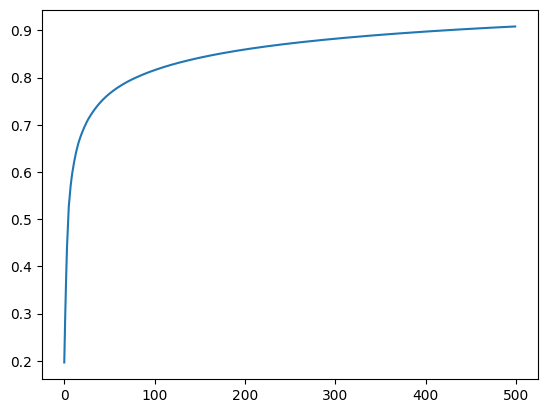

In [7]:
%%time

plt.plot(list(range(pca.n_components_)), cum_evr)
for var in np.arange(0, 1.0, 0.1):
    n_pcs = np.where(cum_evr > var)[0][0]
    print(f"N_pcs={n_pcs} cover {var} of the variance")
n_pcs = np.where(cum_evr > 0.80)[0][0]

transformed = sklearn.decomposition.PCA(n_components=n_pcs).fit_transform(data)
transformed = sklearn.preprocessing.StandardScaler().fit_transform(transformed)

kmeans_pca_40 = sklearn.cluster.KMeans(n_clusters=40).fit(transformed)
kmeans_pca_30 = sklearn.cluster.KMeans(n_clusters=30).fit(transformed)

kmeans_pca_40_labels = kmeans_pca_40.labels_
kmeans_pca_30_labels = kmeans_pca_30.labels_

In [8]:
%%time
joblib.dump(
    kmeans_pca_40, kmeans_dir / f"kmeans_pca_n_pcs_{n_pcs}_k_40.joblib"
)
joblib.dump(
    kmeans_pca_30, kmeans_dir / f"kmeans_pca_n_pcs_{n_pcs}_k_30.joblib"
)

del pca
del transformed
del kmeans_pca_40
del kmeans_pca_30

CPU times: user 520 µs, sys: 6.2 ms, total: 6.72 ms
Wall time: 32.6 ms


Kernel PCA: Gaussian radial basis function with $\sigma = 200$ (see http://dx.doi.org/10.1016/j.procs.2011.08.043)

In [25]:
%%time
kpca_path = pca_dir / "kpca_500_pcs.joblib"

kpca = sklearn.decomposition.KernelPCA(n_components=500, kernel="rbf", gamma=1/200).fit(data)
# joblib.dump(kpca, kpca_path)

# kpca = joblib.load(kpca_path)

cum_evr = np.cumsum(kpca.eigenvalues_ / np.sum(kpca.eigenvalues_))

CPU times: user 2h 11min 22s, sys: 27min 20s, total: 2h 38min 43s
Wall time: 5min 2s


In [ ]:
%%time
plt.plot(list(range(len(kpca.eigenvalues_))), cum_evr)
for var in np.arange(0, 1.0, 0.1):
    n_pcs = np.where(cum_evr > var)[0][0]
    print(f"N_pcs={n_pcs} cover {var} of the variance")
n_pcs = np.where(cum_evr > 0.80)[0][0]

transformed = sklearn.decomposition.KernelPCA(n_components=n_pcs).fit_transform(data)
transformed = sklearn.preprocessing.StandardScaler().fit_transform(transformed)

kmeans_kpca_40 = sklearn.cluster.KMeans(n_clusters=40).fit(transformed)
kmeans_kpca_30 = sklearn.cluster.KMeans(n_clusters=30).fit(transformed)

kmeans_kpca_40_labels = kmeans_kpca_40.labels_
kmeans_kpca_30_labels = kmeans_kpca_30.labels_

In [11]:
%%time

joblib.dump(
    kmeans_kpca_40, kmeans_dir / f"kmeans_kpca_n_pcs_{n_pcs}_k_40.joblib"
)
joblib.dump(
    kmeans_kpca_30, kmeans_dir / f"kmeans_kpca_n_pcs_{n_pcs}_k_30.joblib"
)

del kpca
del transformed
del kmeans_kpca_40
del kmeans_kpca_30

CPU times: user 1.57 ms, sys: 172 ms, total: 174 ms
Wall time: 205 ms


In [13]:
%%time

ds = xr.open_dataset(path)

# Add +1 to be conform to the GWL labels
kmeans_pca_40 = joblib.load(
    kmeans_dir / "kmeans_pca_n_pcs_80_k_40.joblib"
)
kmeans_pca_30 = joblib.load(
    kmeans_dir / "kmeans_pca_n_pcs_80_k_30.joblib"
)
kmeans_pca_40_labels = kmeans_pca_40.labels_ + 1
kmeans_pca_30_labels = kmeans_pca_30.labels_ + 1

kmeans_kpca_40 = joblib.load(
    kmeans_dir / "kmeans_kpca_n_pcs_32_k_40.joblib"
)
kmeans_kpca_30 = joblib.load(
    kmeans_dir / "kmeans_kpca_n_pcs_32_k_30.joblib"
)
kmeans_kpca_40_labels = kmeans_kpca_40.labels_ + 1
kmeans_kpca_30_labels = kmeans_kpca_30.labels_ + 1

# Need to convert dates to YYYY-MM-DD to be conform with GWL dataset time stamps.
times = a6.utils.times.time_steps_as_dates(ds, coordinates=coordinates)

results = xr.Dataset(
    data_vars={
        "PCA": (
            ["time", "k"],
            list(zip(kmeans_pca_30_labels, kmeans_pca_40_labels)),
        ),
        "kPCA": (
            ["time", "k"],
            list(zip(kmeans_kpca_30_labels, kmeans_kpca_40_labels)),
        ),
    },
    coords={
        "time": times,
        "k": [30, 40],
    },
    attrs={
        "description": "Resulting LSWR labels from K-Means clustering on PCA and kernel PCA of the ERA5 data (1964-2023)",
    },
)
results.to_netcdf(
    "/p/project1/deepacf/emmerich1/data/pca_kpca_kmeans_lswrs_30_40.nc"
)
results

CPU times: user 111 ms, sys: 15.2 ms, total: 127 ms
Wall time: 150 ms


<xarray.Dataset>
Dimensions:  (time: 21826, k: 2)
Coordinates:
  * time     (time) datetime64[ns] 1964-01-01 1964-01-02 ... 2023-10-03
  * k        (k) int64 30 40
Data variables:
    PCA      (time, k) int32 23 27 19 7 3 7 3 29 3 ... 26 28 8 20 31 5 26 27 12
    kPCA     (time, k) int32 10 31 1 4 1 4 24 22 18 ... 39 11 24 8 39 8 24 8 39
Attributes:
    description:  Resulting LSWR labels from K-Means clustering on PCA and ke...

## Plotting

In [3]:
import matplotlib.ticker


results = xr.open_dataset(
    "/p/project1/deepacf/emmerich1/data/pca_kpca_kmeans_lswrs_30_40_2024_05_15.nc"
)

n_lswr_categories = 40
results_40 = results.sel(k=n_lswr_categories)
gwl = xr.open_dataset(
    "/p/home/jusers/emmerich1/juwels/code/a6/src/tests/data/gwl.nc"
)

# NOTE: Uncomment to save dcv2 to disk, or read from disk
# dcv2 = torch.load(
#     "/p/scratch/deepacf/emmerich1/dcv2/multi-level-all-fields-1964-2023/results/tensors/epoch-799-assignments.pt",
#     map_location=torch.device("cpu"),
# )
# dcv2 = xr.DataArray(
#     # Need to add +1 to be conform with GWL labels
#     dcv2.numpy()[0] + 1,
#     name="DCv2",
#     coords={"time": results["time"]},
#     dims=["time"],
# )
# dcv2.to_netcdf("/p/project1/deepacf/emmerich1/data/dcv2-lswrs.nc")

dcv2 = xr.open_dataset("/p/project1/deepacf/emmerich1/data/dcv2-lswrs.nc")[
    "DCv2"
]

lswrs = [gwl["GWL"], results_40["PCA"], results_40["kPCA"], dcv2]

# Set ggplot styles and update Matplotlib with them.
def grey_background(ax):
    # Give plot a gray background like ggplot.
    ax.set_facecolor('#EBEBEB')
    # Remove border around plot.
    [ax.spines[side].set_visible(False) for side in ax.spines]

def plot_grid_with_grey_background(ax, minor_ticks_x: int = 0, minor_ticks_y: int = 0):
    grey_background(ax)
    
    ax.grid(which='major', color='white', linewidth=1)
    # Show the minor ticks and grid.
    ax.minorticks_on()
    
    if minor_ticks_x > 0:
        ax.xaxis.grid(which='minor', color='white', linewidth=0.5)
        # Now hide the minor ticks (but leave the gridlines).
        ax.tick_params(axis="x", which='minor', bottom=False, left=False)
        # Only show minor gridlines once in between major gridlines.
        ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(minor_ticks_x + 1))
        
    if minor_ticks_y > 0:
        ax.yaxis.grid(which='minor', color='white', linewidth=0.5)
        ax.tick_params(axis="y", which='minor', bottom=False, left=False)
        ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(minor_ticks_y + 1))


In [4]:
pca = joblib.load(pca_dir / "pca_500_pcs.joblib")
kpca = joblib.load(pca_dir / "kpca_500_pcs.joblib")

pca_cum_evr = np.cumsum(pca.explained_variance_ratio_)
# kpca_evr = kpca.eigenvalues_ / np.sum(kpca.eigenvalues_)
# kpca_cum_evr = np.cumsum(kpca_evr)

## Explained Variance Ratio Plots

CPU times: user 1.06 s, sys: 971 ms, total: 2.03 s
Wall time: 1.06 s


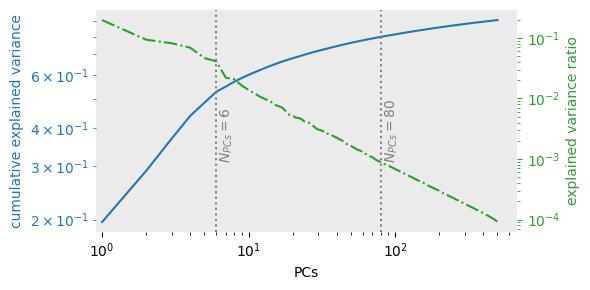

In [5]:
%%time

plt.rcParams['axes.axisbelow'] = True

fig, ax1 = plt.subplots(figsize=(6, 3))

ax1.set_xlabel("PCs")

x = list(range(1, pca.n_components + 1))

# Plot cumulative variance on first axis
ax1_color = "tab:blue"
ax1.set_ylabel("cumulative explained variance", color=ax1_color)
ax1.plot(x, pca_cum_evr, color=ax1_color, linestyle="-", label="PCA")
# ax1.plot(x, kpca_cum_evr, color=ax1_color, linestyle="-.", label="kPCA")

# Create right axis.
ax2 = ax1.twinx()

# Plot the explained variance ratios.
ax2_color = "tab:green"
ax2.set_ylabel("explained variance ratio", color=ax2_color)
ax2.plot(
    x,
    pca.explained_variance_ratio_,
    color=ax2_color,
    linestyle="-.",
    label="",
)
# ax2.plot(x, kpca_evr, color=ax2_color, linestyle="-.", label="kPCA")

for ax, color, log_scale_y in [(ax1, ax1_color, True), (ax2, ax2_color, True)]:
    # Set log scale.
    if log_scale_y:
        ax.set(xscale="log", yscale="log")
    else:
        ax.set(xscale="log")
    # Set left xlim such that the first tick disappears.
    ax.set_xlim(0.91, None)
    # Color the ticks.
    ax.tick_params(axis="y", colors=color, which="both")


# Plot vertical lince indicating variance excess.
variance = 0.8
for cum_evr, title in [(pca_cum_evr, ""),]:# (kpca_cum_evr, "kPCA")]:
    n_pcs = np.where(cum_evr > variance)[0][0]
    # Dashed line indicating the threshold.
    ax2.axvline(
        n_pcs,
        ymin=0,
        ymax=1.1,
        linestyle=":",
        color="grey",
    )
    ax2.text(
        1.04 * n_pcs,
        0.001,
        f"$N_{{PCs}} = {n_pcs}${f' ({title})' if title else ''}",
        rotation=90,
        color="grey",
    )

for n_pcs, title in [(6, ""),]:# (5, "kPCA")]:
    # Dashed line indicating the threshold.
    ax2.axvline(
        n_pcs,
        ymin=0,
        ymax=1.1,
        linestyle=":",
        color="grey",
    )
    ax2.text(
        1.04 * n_pcs,
        0.001,
        f"$N_{{PCs}} = {n_pcs}${f' ({title})' if title else ''}",
        rotation=90,
        color="grey",
    )
# ax2.legend()
grey_background(ax1)
grey_background(ax2)
fig.tight_layout()

plt.savefig(plots / "explained-variance-pca-kpca.pdf")

## LSWR Analysis

In [ ]:
def plot_abundance(
    assignments: list[xr.DataArray],
) -> None:
    n_subplots = len(assignments)
    labels = np.arange(
        int(assignments[0].min()), int(assignments[0].max()) + 1, 1, dtype=int
    )
    x_lims = labels.min() - 0.5, labels.max() + 0.5
    bins = np.arange(x_lims[0], x_lims[1] + 1.0, 1.0)
    colors = _colors.create_colors_for_labels(labels)

    fig, axs = plt.subplots(
        figsize=(6, 2 * n_subplots),
        nrows=n_subplots,
        ncols=1,
        sharex=True,
        sharey=True,
    )

    plt.title(f"Abundance of LSWRs")

    for i, element in enumerate(assignments):
        _, _, patches = axs[i].hist(element, bins=bins, density=True)

        axs[i].set_title(element.name)

        if i == n_subplots - 1:
            axs[i].set_xlabel("LSWR")

        axs[i].set_ylabel("Abundance [%]")
        axs[i].set_xlim(*x_lims)
        axs[i].set_xticks(labels)
        axs[i].set_xticklabels(labels, rotation=90)
        axs[i].yaxis.grid(True)

        # ax2 = axs[i].twinx()
        # _, _, patches = ax2.hist(element, bins=bins, density=True)
        # ax2.set_ylabel("Relative [%]")

        if len(colors) != len(patches):
            raise RuntimeError(
                "Length of colors does not match number of patches in histogram"
            )

        for color, patch in zip(colors, patches):
            patch.set_facecolor(color)

    fig.tight_layout()
    plt.savefig(plots / "lswrs-abundance-comparison.pdf")


plot_abundance(lswrs)

In [ ]:
%%time

import seaborn as sns
import itertools

import matplotlib.colors


def plot_transition_matrix_heatmap(
    assignments: list[xr.DataArray],
) -> None:
    n_subplots = len(assignments)
    width_ratios = [1 for _ in enumerate(assignments)] + [0.08]

    # Add 1 subplot just for the colorbar
    fig, axs = plt.subplots(
        figsize=(6 * n_subplots, 6),
        nrows=1,
        ncols=n_subplots + 1,
        gridspec_kw={"width_ratios": width_ratios},
    )

    # Last element of axs is the cbar
    for ax1, ax2 in itertools.pairwise(axs[:-1]):
        ax1.sharey(ax2)

    axs_cbar = axs[-1]
    transitions = np.array(
        [
            a6.plotting.transitions._calculate_markov_transition_matrix(a)
            for a in assignments
        ]
    )
    max_prob = transitions.max()
    min_prob = transitions.min()

    for i, element in enumerate(assignments):
        transition = transitions[i]
        kwargs = (
            {"cbar": False}
            if i < n_subplots - 1
            else {"cbar_ax": axs_cbar, "cbar_kws": {"label": "probability"}}
        )
        sns.heatmap(
            transition,
            ax=axs[i],
            cmap="Reds",
            vmin=min_prob,
            vmax=max_prob,
            square=True,
            norm= matplotlib.colors.LogNorm(),
            **kwargs
        )
        axs[i].set_title(element.name)
    fig.tight_layout()
    plt.savefig(plots / "lswrs-transition-probabilities-comparison.pdf")


plot_transition_matrix_heatmap(lswrs)

In [ ]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def convert(x):
    return x.total_seconds() / 60 / 60 / 24


def plot_modes_durations(
    assignments: list[xr.DataArray],
) -> tuple[plt.Figure, plt.Axes]:
    """Plot the mode mean durations and standard deviation."""
    n_subplots = len(assignments)
    modes = [
        a6.modes.methods.determine_lifetimes_of_modes(a) for a in assignments
    ]
    labels = np.arange(1, modes[0].size + 1, 1, dtype=int)

    x_lims = labels.min() - 0.5, labels.max() + 0.5
    colors = _colors.create_colors_for_labels(labels)

    fig, axs = plt.subplots(
        figsize=(6, 2 * n_subplots),
        nrows=n_subplots,
        ncols=1,
        sharex=True,
        sharey=True,
    )

    for i, element in enumerate(modes):
        name = assignments[i].name
        print(name)
        # (
        #     durations,
        #     stds,
        # ) = a6.plotting.modes.statistics._calculate_mean_durations_and_standard_deviations(
        #     element
        # )
        # axs[i].bar(
        #     labels,
        #     durations,
        #     yerr=stds,
        #     width=1.0,  # removes gaps between the bars
        #     color=colors,
        #     align="center",
        #     alpha=1,
        #     ecolor="black",
        #     capsize=3,
        # )

        durations = [
            [appearance.duration.days for appearance in e.appearances]
            for e in element
        ]
        # parts = axs[i].boxplot(
        #     durations,
        #     showmeans=True,
        #     showfliers=False,
        #     showcaps=False,
        # )
        parts = axs[i].violinplot(
            durations,
            widths=1,
            showmeans=True,
            showmedians=True,
            showextrema=True,
            quantiles=[[0.95] for _ in enumerate(durations)],
        )

        parts["cmeans"].set_color("green")
        parts["cmedians"].set_color("orange")
        # parts["cmins"].set_alpha(0.0)
        parts["cmaxes"].set_color("red")
        parts["cbars"].set_alpha(0.0)
        parts["cquantiles"].set_color("blue")

        for color, pc in zip(colors, parts["bodies"]):
            pc.set_facecolor("black")
            # pc.set_edgecolor(color)
            pc.set_alpha(0.3)

        axs[i].set_title(name)

        if i == n_subplots - 1:
            axs[i].set_xlabel("LSWR")

        axs[i].set_ylabel("Duration [days]")
        axs[i].set_xlim(*x_lims)
        axs[i].set_xticks(labels)
        axs[i].set_xticklabels(labels, rotation=90)
        axs[i].yaxis.grid(True)
        axs[i]

    fig.tight_layout()
    plt.savefig(plots / "lswrs-durations-comparison.pdf")


plot_modes_durations(lswrs)

In [ ]:
%%time


def calculate_mean_and_std(data: xr.Dataset, assignments: xr.DataArray):
    subset = (
        a6.datasets.methods.select.select_levels(levels=500)
        >> a6.features.methods.geopotential.calculate_geopotential_height()
    ).apply_to(data)

    modes = a6.modes.methods.determine_lifetimes_of_modes(assignments)
    dates = [list(mode.get_dates()) for mode in modes]
    z_h_per_mode = [
        subset[variables.geopotential_height].sel(time=date, method="nearest") 
        for date in dates
    ]

    means = [z_h.mean("time") for z_h in z_h_per_mode]
    means_max = max(mean.max() for mean in means)
    means_min = min(mean.min() for mean in means)

    stds = [z_h.std("time") for z_h in z_h_per_mode]
    stds_max = max(std.max() for std in stds)
    stds_min = min(std.min() for std in stds)

    return (
        assignments.name,
        modes,
        means,
        means_min,
        means_max,
        stds,
        stds_min,
        stds_max,
    )


means_stds = [
    calculate_mean_and_std(data=ds, assignments=assignments)
    for assignments in lswrs
]

In [ ]:
%%time
import cartopy.crs as ccrs


def round_to_decade(value: xr.DataArray) -> int:
    return int(np.round(value.values, -1))


def plot_geopotential_mean_and_std(
    name: str,
    modes,
    means: list[xr.DataArray],
    means_min: float,
    means_max: float,
    stds: list[xr.DataArray],
    stds_min: float,
    stds_max: float,
) -> tuple[plt.Figure, plt.Axes]:
    """Plot geopotential height contours, temperature and wind speed."""
    labels = np.arange(1, modes.size + 1, 1, dtype=int)

    n_rows = 8
    n_cols = 5

    if n_rows * n_cols != labels.max():
        raise ValueError("Number of plots not equal to number of LSWRs")

    height = n_rows * 2
    width = n_cols * 2.5

    fig, axs = plt.subplots(
        figsize=(width, height),
        nrows=n_rows,
        # Add 2 columns for colorbars
        # ncols=n_cols + 2,
        ncols=n_cols,
        subplot_kw=a6.plotting.coastlines.create_projection(),
        # gridspec_kw={"width_ratios": [1 for _ in range(n_cols)] + [0.05, 0.05]},
    )
    levels = list(
        range(
            round_to_decade(means_min),
            round_to_decade(means_max),
            5,
        )
    )

    for i, ax in enumerate(axs.flatten()):
        z_h_mean = means[i]
        z_h_std = stds[i]
        heatmap = z_h_std.plot(
            ax=ax,
            cmap="RdBu",
            vmin=stds_min,
            vmax=stds_max,
            add_colorbar=False,
        )

        contours = z_h_mean.plot.contour(
            ax=ax,
            levels=levels,
            cmap="cool",
            transform=ccrs.PlateCarree(),
            linewidths=1.0,
        )
        # contours.clabel(inline=True)
        #         handles_unfilled, labels = cs_unfilled.legend_elements()

        #         ax.legend(handles_filled + handles_unfilled,
        #                   ["range(2-3)", "range(3-4)", "range(4-6)", "3", "4", "6"],
        #                   ncols=2)
        ax.coastlines(alpha=0.5)
        # ax.gridlines(draw_labels=["left", "bottom"])
        ax.set_title(f"{i + 1}")
    fig.suptitle(name)
    # fig.colorbar(heatmap, ax=axs[:,-2], label=r"$\mu(z_\mathrm{500})$ [m]")
    fig.tight_layout()
    plt.savefig(plots / f"lswrs-geopotential-heights-{name}.pdf")


for mean_std in means_stds:
    plot_geopotential_mean_and_std(*mean_std)

## Wind speed distributions

In [ ]:
def plot_modes_wind_speed(
    data: xr.Dataset, assignments: list[xr.DataArray],
) -> tuple[plt.Figure, plt.Axes]:
    """Plot the mode wind speeds."""
    n_subplots = len(assignments)

    subset = (
        a6.datasets.methods.select.select_levels(levels=950)
        >> a6.features.methods.wind.calculate_wind_speed()
    ).apply_to(data)


    fig, axs = plt.subplots(
        figsize=(6, 2 * n_subplots),
        nrows=n_subplots,
        ncols=1,
        sharex=True,
        sharey=True,
    )

    for i, method in enumerate(assignments):
        name = method.name
        print(name)

        modes = a6.modes.methods.determine_lifetimes_of_modes(method)
        labels = np.arange(1, modes.size + 1, 1, dtype=int)
        x_lims = labels.min() - 0.5, labels.max() + 0.5
        colors = _colors.create_colors_for_labels(labels)

        appearances = [list(mode.get_dates()) for mode in modes]
        wind_speeds = [
            subset[variables.wind_speed].sel(time=dates, method="nearest").values.flatten()
            for dates in appearances
        ]

        parts = axs[i].violinplot(
            wind_speeds,
            widths=1,
            showmeans=True,
            showmedians=True,
            showextrema=True,
            quantiles=[[0.95] for _ in enumerate(wind_speeds)],
        )

        parts["cmeans"].set_color("green")
        parts["cmedians"].set_color("orange")
        # parts["cmins"].set_alpha(0.0)
        parts["cmaxes"].set_color("red")
        parts["cbars"].set_alpha(0.0)
        parts["cquantiles"].set_color("blue")

        for color, pc in zip(colors, parts["bodies"]):
            pc.set_facecolor("black")
            # pc.set_edgecolor(color)
            pc.set_alpha(0.3)

        axs[i].set_title(name)

        if i == n_subplots - 1:
            axs[i].set_xlabel("LSWR")

        axs[i].set_ylabel("wind speed [m/s]")
        axs[i].set_xlim(*x_lims)
        axs[i].set_xticks(labels)
        axs[i].set_xticklabels(labels, rotation=90)
        axs[i].yaxis.grid(True)
        axs[i]
        break

    fig.tight_layout()
    plt.savefig(plots / "lswrs-wind-speed-comparison.pdf")


plot_modes_wind_speed(data=ds, assignments=lswrs)

## Clean production data for plotting

In [ ]:
%%time

"""
NOTE: Preprocess turbine data. This takes ~22 min, so prefer loading (cell below)
if no changes to the preprocessing are required.
"""

paths = list(
    pathlib.Path("/p/home/jusers/emmerich1/juwels/data/production").glob(
        "**/*.nc"
    )
)
print(paths)


def remove_outliers(data: xr.Dataset) -> xr.Dataset:
    power_rating = float(data.attrs["power rating"].split()[0])
    print(power_rating)
    # Only use data points where
    # - production is lower than power rating
    # - production is greater than 0
    return a6.datasets.methods.turbine.clean_production_data(
        power_rating=power_rating,
    ).apply_to(data)


# Contains the turbine name and the production
turbines: dict[str, xr.Dataset] = {
    path.name: remove_outliers(xr.open_dataset(path)) for path in paths
}

# NOTE: Uncomment to save preprocessed data to disk.

for name, data in turbines.items():
    data.to_netcdf(
        f"/p/home/jusers/emmerich1/juwels/data/production-cleaned-for-analysis/{name}.nc"
    )

In [ ]:
# Open preprocessed turbine data if available
paths = list(
    pathlib.Path(
        "/p/home/jusers/emmerich1/juwels/data/production-cleaned-for-analysis"
    ).glob("**/*.nc")
)
# Contains the turbine name and the production
turbines: dict[str, xr.Dataset] = {
    path.name: xr.open_dataset(path) for path in paths
}

## Relation of LSWRs to Power Production

In [ ]:
%%time

import dataclasses
import datetime


@dataclasses.dataclass
class PowerPerMode:
    label: int
    measurements: list[int] = dataclasses.field(default_factory=list)
    sum: list[float] = dataclasses.field(default_factory=list)
    mean: list[float] = dataclasses.field(default_factory=list)
    std: list[float] = dataclasses.field(default_factory=list)
    normalized_mean: list[float] = dataclasses.field(default_factory=list)
    normalized_std: list[float] = dataclasses.field(default_factory=list)


def get_power_per_lswr(data: xr.Dataset) -> dict[int, PowerPerMode]:
    modes = a6.modes.methods.determine_lifetimes_of_modes(data)
    dates = [xr.DataArray(list(mode.get_dates())) for mode in modes]

    power_per_mode = {
        mode.label: PowerPerMode(label=mode.label) for mode in modes
    }

    for i, (name, turbine) in enumerate(turbines.items()):
        print(f"{data.name}: {i}/{len(turbines)}", end="\r")
        power_rating = float(turbine.attrs["power rating"].split()[0])

        # Resample to daily production and calculate sum, relative mean and std
        resampled = turbine["production"].resample({"time": "1d"}, skipna=True)
        daily_sum = resampled.sum(skipna=True)
        daily_mean = resampled.mean(skipna=True)
        daily_mean_normalized = daily_mean / power_rating
        daily_std = resampled.std(skipna=True)
        daily_std_normalized = daily_std / power_rating

        for mode, date in zip(modes, dates, strict=True):
            mode_power = power_per_mode[mode.label]

            # Get time steps of production where LSWR appeared
            intersection = sorted(set(daily_sum.time.values) & set(date.values))

            # if not intersection:
            #     print(f"WARNING: empty intersection for {name} and mode {mode.label}")
            #     continue

            # Count number of days that contribute to the results
            mode_power.measurements.append(len(intersection))

            # Select time steps of LSWR appearance and calculate sum
            total = daily_sum.sel(time=intersection)
            mode_power.sum.extend(total.values.flatten().tolist())

            # Select time steps of LSWR appearance and calculate mean
            mean = daily_mean.sel(time=intersection)
            mean_normalized = daily_mean_normalized.sel(time=intersection)
            mode_power.mean.extend(mean.values.flatten().tolist())
            mode_power.normalized_mean.extend(
                mean_normalized.values.flatten().tolist()
            )

            # Select time steps of LSWR appearance and calculate std
            std = daily_std.sel(time=intersection)
            std_normalized = daily_std_normalized.sel(time=intersection)
            mode_power.std.extend(std.values.flatten().tolist())
            mode_power.normalized_std.extend(
                std_normalized.values.flatten().tolist()
            )
    return power_per_mode


power_per_method = {lswr.name: get_power_per_lswr(lswr) for lswr in lswrs}

In [ ]:
import pandas as pd

latex_code = []


def power_mean_with_std_as_string(stats: list[float]) -> str:
    return f"${np.nanmean(stats) * 100:.2f} \pm {np.nanstd(stats) * 100:.2f}$"


columns = {
    "$N$": lambda lswrs: [
        np.nansum(results.measurements) for results in lswrs.values()
    ],
    "$P_{\mathrm{total}}$ [kW]": lambda lswrs: [
        f"{int(np.nansum(results.sum)):d}" for results in lswrs.values()
    ],
    "$P^{\mathrm{mean}}_{\mathrm{normalized}}$ [\%]": lambda lswrs: [
        power_mean_with_std_as_string(results.normalized_mean)
        for results in lswrs.values()
    ],
    "$P^{\mathrm{std}}_{\mathrm{normalized}}$ [\%]": lambda lswrs: [
        power_mean_with_std_as_string(results.normalized_std)
        for results in lswrs.values()
    ],
}

reform = {
    (name, column): func(method)
    for name, method in power_per_method.items()
    for column, func in columns.items()
}

df = pd.DataFrame.from_dict(reform)

# Add 1 to start indexing at 1 to be conform with LSWR labels
df.index += 1

code = df.to_latex(
    float_format="%.2f",
    label="production-per-lswr-per-method",
    caption=f"Power production for the resulting LSWRs.",
)


with open(
    "/p/home/jusers/emmerich1/juwels/code/a6/notebooks/power-production-table.tex",
    "w",
) as f:
    f.write(code)

df

In [ ]:
import matplotlib.pyplot as plt


def plot_power_per_mode(
    powers: dict[str, dict[int, PowerPerMode]],
) -> tuple[plt.Figure, plt.Axes]:
    """Plot the power production for each LSWR and method."""
    n_rows = len(powers)
    n_cols = 1
    labels = np.arange(1, n_lswr_categories + 1, dtype=int)

    x_lims = labels.min() - 0.5, labels.max() + 0.5
    colors = _colors.create_colors_for_labels(labels)

    fig, axs = plt.subplots(
        figsize=(6 * n_cols, 2 * n_rows),
        nrows=n_rows,
        ncols=n_cols,
        sharex=True,
        sharey=True,
    )

    plt.title(f"Power production per LSWRs")

    for i, (method, powers_per_lswr) in enumerate(powers.items()):
        powers_means = [
            np.nanmean(power.normalized_mean) * 100
            for power in powers_per_lswr.values()
        ]
        powers_stds = [
            np.nanstd(power.normalized_mean) * 100
            for power in powers_per_lswr.values()
        ]
        ax = axs[i]

        ax.bar(
            labels,
            powers_means,
            yerr=powers_stds,
            width=1.0,  # removes gaps between the bars
            color=colors,
            align="center",
            alpha=1,
            ecolor="black",
            capsize=3,
        )
        parts = axs[i].violinplot(
            durations,
            widths=1,
            showmeans=True,
            showmedians=True,
            showextrema=False,
            quantiles=[[0.95] for _ in enumerate(durations)],
        )

        parts["cmeans"].set_color("red")
        parts["cmedians"].set_color("orange")
        # parts["cmins"].set_alpha(0.0)
        parts["cquantiles"].set_color("blue")

        for color, pc in zip(colors, parts["bodies"]):
            pc.set_facecolor("black")
            # pc.set_edgecolor(color)
            pc.set_alpha(0.5)

        ax.set_title(method)

        if i == n_rows - 1:
            ax.set_xlabel("LSWR")

        ax.set_ylabel(r"$P^{\mathrm{mean}}_{\mathrm{normalized}}$ [%]")
        ax.set_xlim(*x_lims)
        ax.set_xticks(labels)
        ax.set_xticklabels(labels, rotation=90)
        ax.yaxis.grid(True)

    fig.tight_layout()
    plt.savefig(plots / "lswrs-power-production-comparison.pdf")


plot_power_per_mode(power_per_method)

In [6]:
ssds_pca = joblib.load(plots / "../data/scree-test-results-pca.dict")
ssds_kpca = joblib.load(plots / "../data/scree-test-results-kpca.dict")

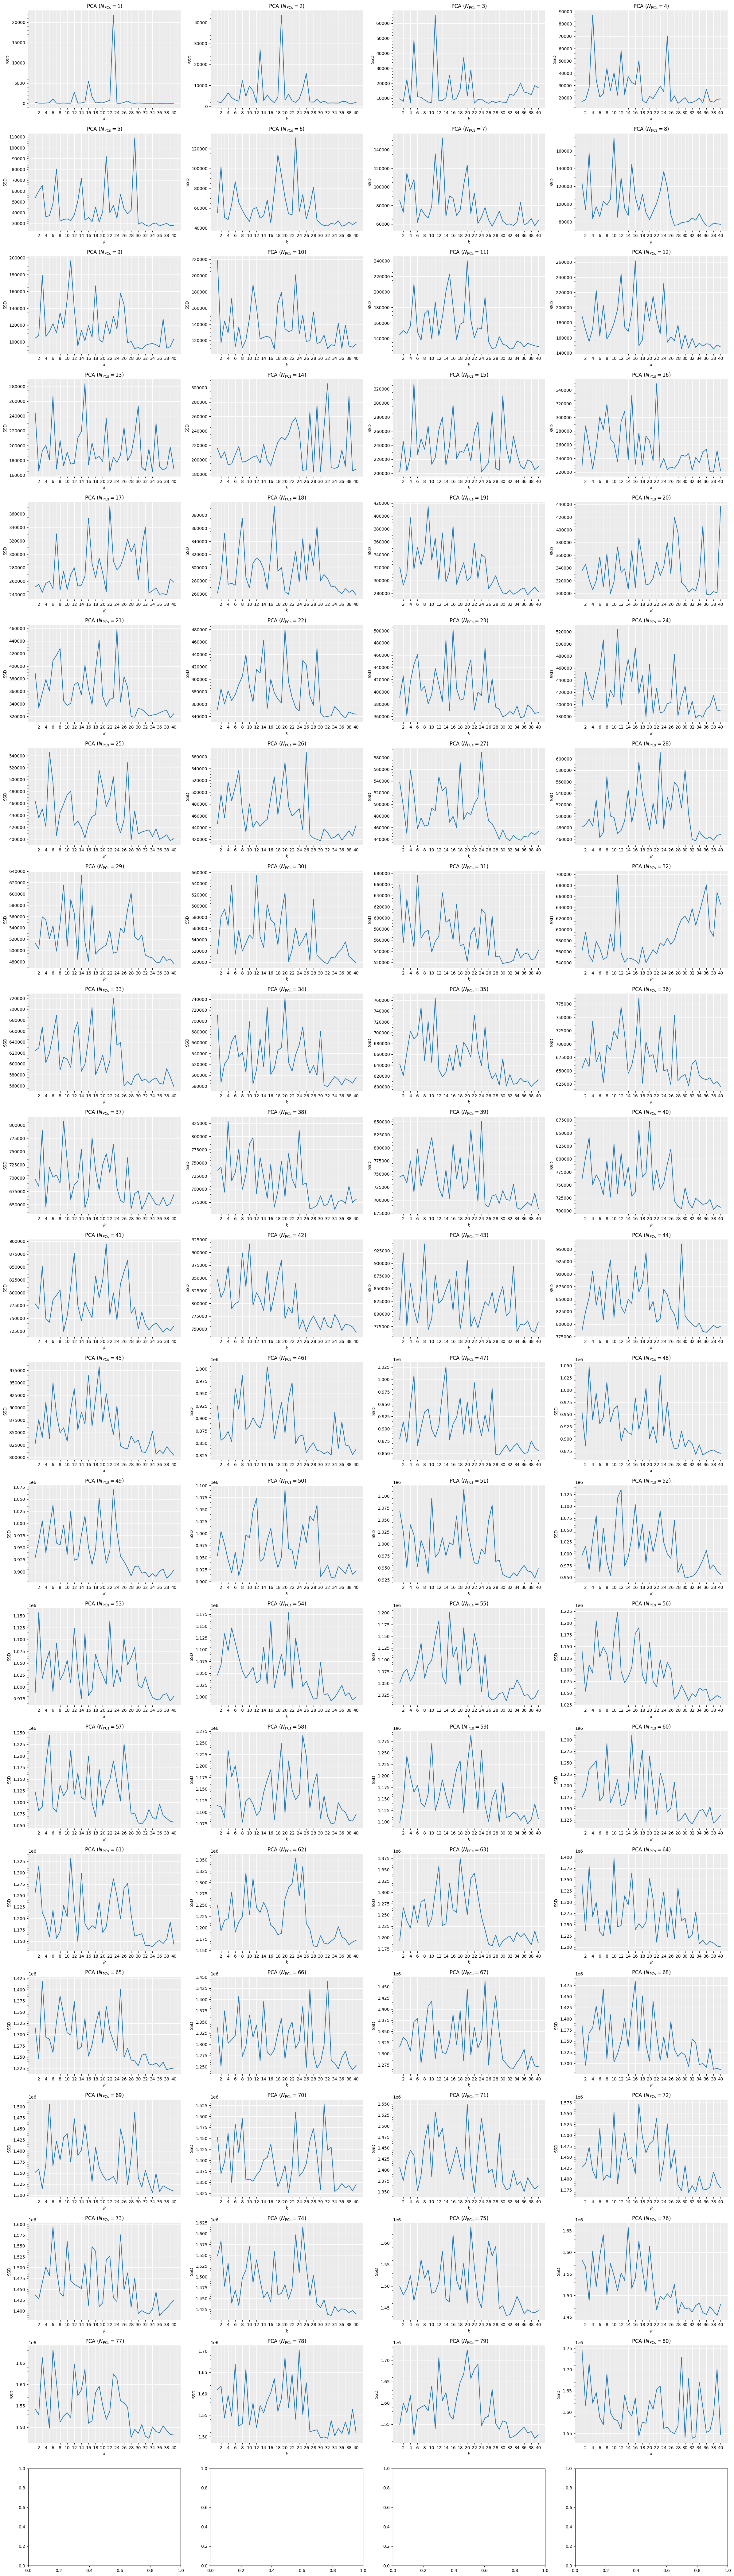

In [7]:
def plot_scree_test_results(ssds, method: str):
    ks = range(1, len(ssds[2]) + 1)

    ncols = 4
    nrows = (len(ssds) // ncols) + 1
    fig, axs = plt.subplots(figsize=(6 * ncols, 4 * nrows), nrows=nrows, ncols=ncols)

    axs_flat = axs.flatten()
    for i, (n_pcs, ssd) in enumerate(ssds.items()):
        ax = axs_flat[i]
        ax.plot(
            ks,
            list(ssd.values()),
            c="tab:blue",
            # linestyle="-",
            # marker="o",
        )
        ax.set_title(rf"{method.upper()} $(N_{{\mathrm{{PCs}}}} = {n_pcs})$")

        ax.set_xlabel(r"$k$")
        ax.set_xticks(ks[1::2])
        ax.set_xticklabels([str(k) for k in ks[1::2]])
        ax.set_ylabel("SSD")
        plot_grid_with_grey_background(ax, minor_ticks_x=1)

    fig.tight_layout()
    plt.savefig(plots / f"kmeans-scree-test-{method}.pdf")

plot_scree_test_results(ssds=ssds_pca, method="pca")

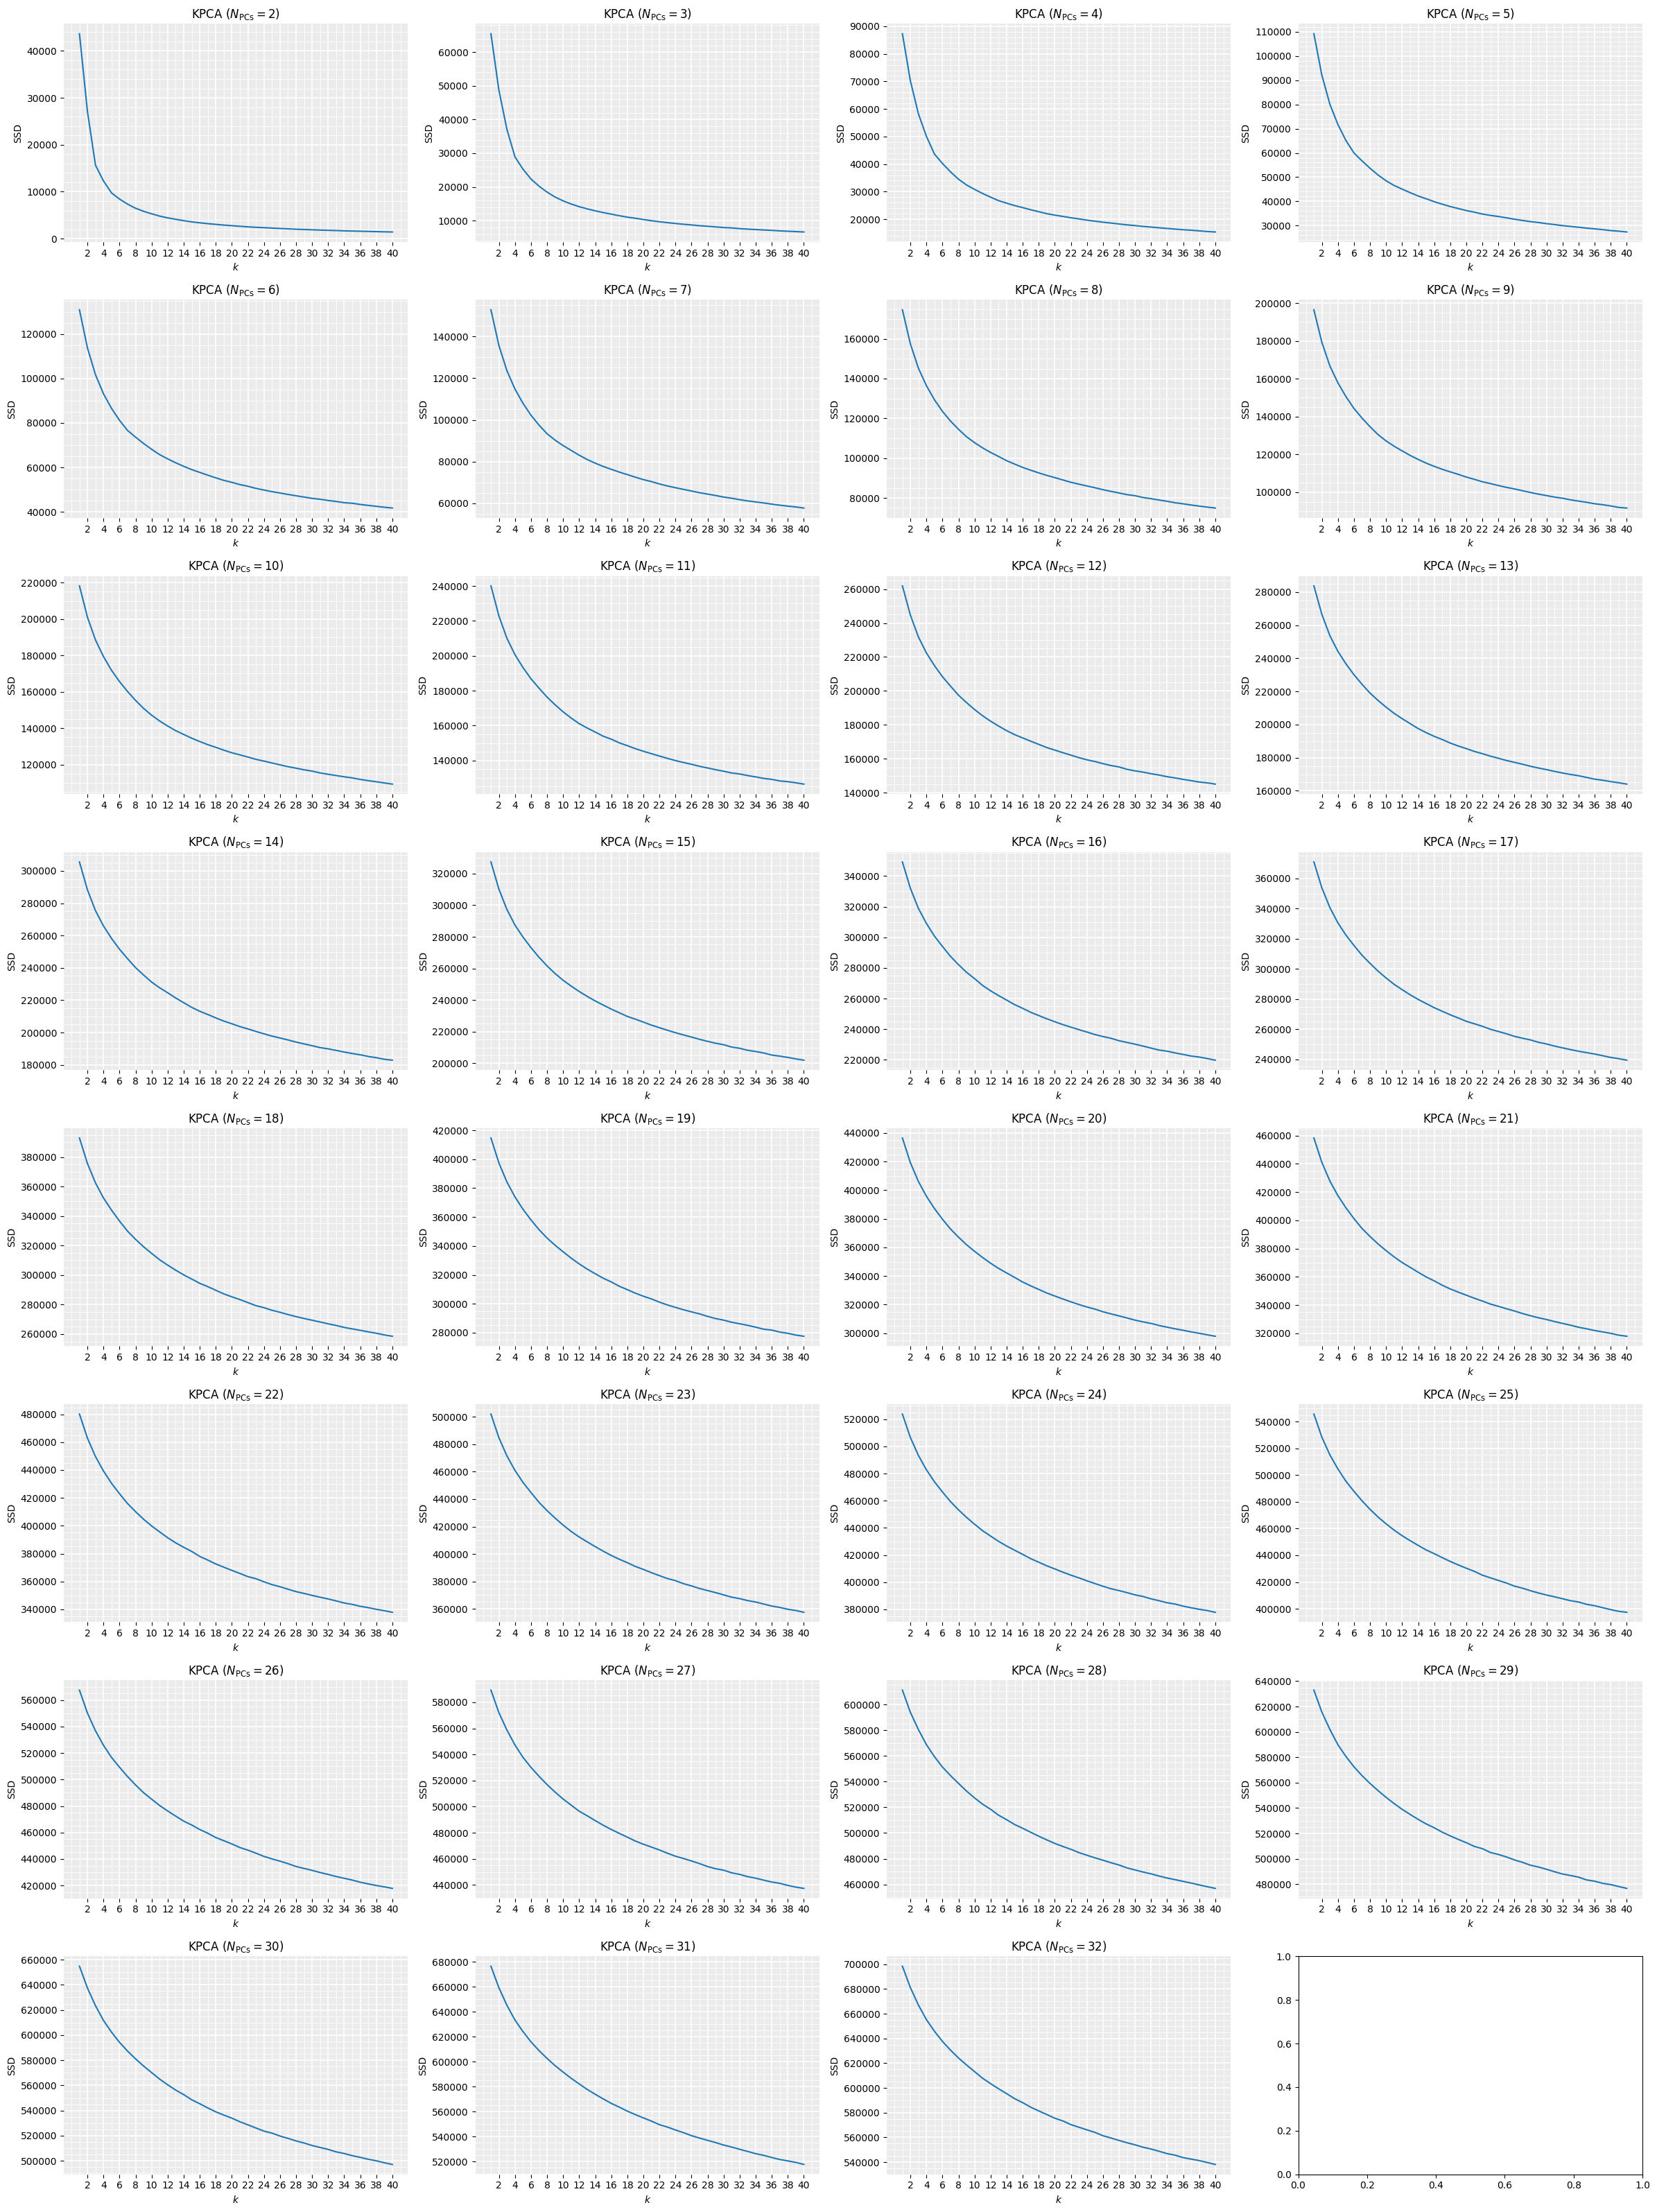

In [39]:
plot_scree_test_results(ssds=ssds_kpca, method="kpca")

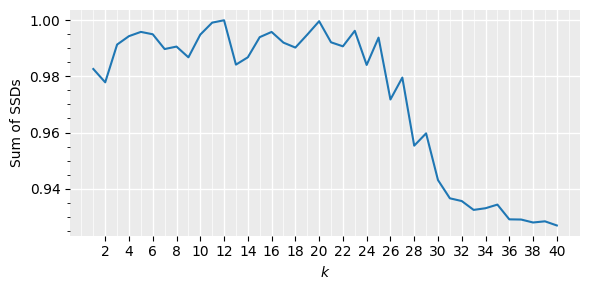

In [50]:
def plot_scree_test_results_sum_of_ssds(ssds, method):
    ks = range(1, len(ssds[2]) + 1)

    fig, ax = plt.subplots(figsize=(6,3))
    values = np.array([0.0 for _ in ks])
    for ssd in ssds.values():
        values += np.array(list(ssd.values()))

    ax.plot(
        ks,
        values / values.max(),
        c="tab:blue",
        # linestyle="-",
        # marker="o",
    )
    ax.set_xlabel(r"$k$")
    ax.set_xticks(ks[1::2])
    ax.set_xticklabels([str(k) for k in ks[1::2]])
    ax.set_ylabel("Sum of SSDs")
    plot_grid_with_grey_background(ax, minor_ticks_x=1)

    fig.tight_layout()
    plt.savefig(plots / f"kmeans-scree-test-{method}-sum-of-ssds.pdf")
plot_scree_test_results_sum_of_ssds(ssds=ssds_pca, method="pca")
# plot_scree_test_results_sum_of_ssds(ssds=ssds_kpca, method="kpca")

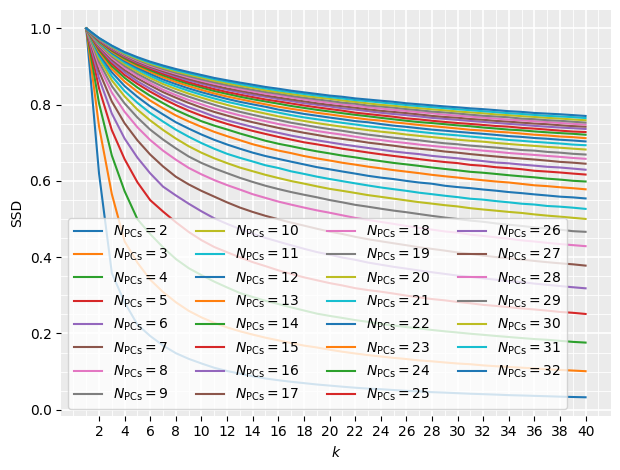

In [38]:
ks = range(1, len(ssds_kpca[2]) + 1)

nrows = len(ssds_kpca)
ncols = 1
# fig, axs = plt.subplots(figsize=(6 * ncols, 4 * nrows), nrows=nrows, ncols=ncols, sharex=True)
# axs_flat = axs.flatten()

fig, ax = plt.subplots()

for i, (n_pcs, ssd) in enumerate(ssds_kpca.items()):
    # ax = axs_flat[i]
    values = np.array(list(ssd.values()))
    values_normalized = values / values.max()
    ax.plot(
        ks,
        values_normalized,
        # linestyle="-",
        # marker="o",
        label=rf"$N_{{\mathrm{{PCs}}}} = {n_pcs}$",
    )

ax.set_xlabel(r"$k$")
ax.set_xticks(ks[1::2])
ax.set_xticklabels([str(k) for k in ks[1::2]])
ax.set_ylabel("SSD")

plot_grid_with_grey_background(ax, minor_ticks_x=1)

plt.legend(ncols=4)

fig.tight_layout()
plt.savefig(plots / "kmeans-scree-test-kpca.pdf")